# Training with attention mechanism

## Importing Libraries and Parameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to load all the files
DATAPATH = './preprocessed/'

In [ ]:
# Importing libraries

import pandas as pd
import numpy as np
import random as rn
import re
from datetime import datetime
import time
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Embedding, LSTM, Dense, Softmax
from tensorflow.keras.layers import Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
#-------------------------------------
# Parameters
#-------------------------------------

# fixing numpy RS
np.random.seed(42)
# fixing tensorflow RS
tf.random.set_seed(32)
# python RS
rn.seed(12)

# Taking maximum words 38
MAXLEN = 39
QSN_VOCAB_SIZE = 46789
ANS_VOCAB_SIZE = 25445

EMBEDDING_SIZE = 300

LSTM_UNITS = 128
BATCH_SIZE = 480

## Loading Data

In [ ]:
# Loading data
train, validation = pickle.load(open(DATAPATH+'spelldata_train_val.pkl', 'rb'))

In [ ]:
# Load tokenizers
enc_tokenizer, dec_tokenizer = pickle.load(open(DATAPATH+'spelltokenizer_obj.pkl', 'rb'))

In [ ]:
# Load encoded data
train_encoder_inp, train_decoder_inp, train_decoder_out = pickle.load(open(DATAPATH+'spelltrain_tokens.pkl', 'rb'))
val_encoder_inp, val_decoder_inp, val_decoder_out = pickle.load(open(DATAPATH+'spellval_token.pkl', 'rb'))

In [ ]:
# Load embedding matrix
qsn_embedding_matrix, ans_embedding_matrix = pickle.load(open(DATAPATH+'spellembedding_matrix.pkl', 'rb'))

## Building Layers and Model

### Encoder

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence
    returns encoder-outputs, encoder_final_state_h, encoder_final_state_c
    '''
    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_dim = embedding_size
        self.lstm_units = lstm_size
        self.input_length = input_length
        self.enc_output = self.enc_state_h = self.enc_state_c = 0
        
        #Initialize Embedding layer, output shape: (batch_size, input_length, embedding_dim)
        self.embedding = Embedding(self.vocab_size, self.embedding_dim,
                                   embeddings_initializer=tf.keras.initializers.Constant(qsn_embedding_matrix), trainable=False,
                                   input_length=self.input_length, mask_zero=True, name="encoder_Embedding")
        
        #Intialize Encoder LSTM layer
        self.lstm = LSTM(units=self.lstm_units, activation='tanh', recurrent_activation='sigmoid',
                         kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26),
                         recurrent_initializer=tf.keras.initializers.orthogonal(seed=54),
                         bias_initializer=tf.keras.initializers.zeros(),
                         return_state=True, return_sequences=True, name="encoder_LSTM")
        
        # Bidirectional layer
        self.bidirectional = Bidirectional(self.lstm)


    def call(self, input_sequence, states):
        '''
          This function takes a sequence input and the initial states of the encoder.
        '''
        # Embedding inputs, using pretrained glove vectors
        # shape: (input_length, glove vector's dimension)
        embedded_input = self.embedding(input_sequence)
        # mask for padding
        mask = self.embedding.compute_mask(input_sequence)
        # enc_out shape: (batch_size, input_length, lstm_size) & forward or backward h and c: (batch_size, lstm_size)
        self.enc_out, enc_fw_state_h, enc_bw_state_h, enc_fw_state_c, enc_bw_state_c = self.bidirectional(embedded_input, mask=mask)
        
        # Concatenating forward and backward states
        # enc_state_h and c shape: (batch_size, 2*lstm_size)
        self.enc_state_h = Concatenate()([enc_fw_state_h, enc_bw_state_h])
        self.enc_state_c = Concatenate()([enc_fw_state_c, enc_bw_state_c])
        return self.enc_out, self.enc_state_h, self.enc_state_c, mask


    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      '''
      # shape: batch_size,input_length,lstm_size
      return (tf.zeros([batch_size, 2*self.lstm_units]), tf.zeros([batch_size, 2*self.lstm_units]))

In [ ]:
# Checking its output and shape
vocab_size=10
embedding_size=20
lstm_size=32
input_length=10
batch_size=16
encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
initial_state=encoder.initialize_states(batch_size)
encoder_output,state_h,state_c, enc_mask=encoder(input_sequence,initial_state)

print(encoder_output.shape, state_h.shape, state_c.shape, enc_mask.shape)

(16, 10, 64) (16, 64) (16, 64) (16, 10)


### Attention

In [ ]:
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self,scoring_function, att_units):
        super().__init__()
        self.scoring_function = scoring_function
        self.att_units = att_units

        # Initializing for 3 kind of losses
        if self.scoring_function=='dot':
            # Intialize variables needed for Dot score function here
            self.dot = tf.keras.layers.Dot(axes=[2,2])
        if scoring_function == 'general':
            # Intialize variables needed for General score function here
            self.wa = Dense(self.att_units)
        elif scoring_function == 'concat':
            # Intialize variables needed for Concat score function here
            self.wa = Dense(self.att_units, activation='tanh')
            self.va = Dense(1)
  
  
    def call(self,decoder_hidden_state,encoder_output, enc_mask):
        '''
        Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
        '''
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=1)

        # mask from encoder
        enc_mask = tf.expand_dims(enc_mask, axis=-1)
        
        # score shape: (batch_size, input_length, 1)
        if self.scoring_function == 'dot':
            # Implementing Dot score function
            score = self.dot([encoder_output, decoder_hidden_state])
        elif self.scoring_function == 'general':
            # Implementing General score function here            
            score = tf.keras.layers.Dot(axes=[2, 2])([self.wa(encoder_output), decoder_hidden_state])
        elif self.scoring_function == 'concat':
            # Implementing General score function here
            decoder_output = tf.tile(decoder_hidden_state, [1, encoder_output.shape[1], 1])
            score = self.va(self.wa(tf.concat((decoder_output, encoder_output), axis=-1)))
            
        score = score + (tf.cast(tf.math.equal(enc_mask, False), score.dtype)*-1e9)
        # shape: (batch_size, input_length, 1)
        attention_weights = Softmax(axis=1)(score)
        
        enc_mask = tf.cast(enc_mask, attention_weights.dtype)
        # masking attention weights
        attention_weights = attention_weights * enc_mask
        context_vector = attention_weights * encoder_output
        
        # shape = (batch_size, dec lstm units)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
# Checking its shape and outputs
input_length=10
batch_size=16
att_units=32
scoring_fun = 'concat'

state_h=tf.random.uniform(shape=[batch_size,att_units])
encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
encoder_mask = tf.cast(tf.random.uniform(shape=[batch_size, input_length]), dtype=bool)
#encoder_mask = tf.cast(tf.zeros(shape=[batch_size, input_length]), dtype=bool)
attention=Attention(scoring_fun,att_units)
context_vector,attention_weights=attention(state_h,encoder_output, encoder_mask)
print(context_vector.shape, attention_weights.shape)

(16, 32) (16, 10, 1)


### Onestep Deocoder

In [ ]:
class OneStepDecoder(tf.keras.Model):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        """
        In this layer calculate the ooutput for a single timestep
        """
        super().__init__()

        # Initialize decoder embedding layer, LSTM and any other objects needed
        self.vocab_size = tar_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units

        self.embedding = Embedding(self.vocab_size, self.embedding_dim,
                                    embeddings_initializer=tf.keras.initializers.Constant(ans_embedding_matrix), trainable=False,
                                    input_length=self.input_length, mask_zero=True, name="Att_Dec_Embedding")

        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Att_Dec_LSTM")
        self.fc = Dense(self.vocab_size)
        # attention layers
        self.attention = Attention(self.score_fun, self.att_units)


    def call(self,input_to_decoder, encoder_output, state_h, state_c, enc_mask):
        '''
        Calling this function by passing decoder input for a single timestep, encoder output and encoder final states
        '''
        # shape: (batchsize, input_length, embedding dim)
        embedded_input = self.embedding(input_to_decoder)
        # shape: (batch_size, dec lstm units)
        context_vector, attention_weights = self.attention(state_h, encoder_output, enc_mask)
        # (batch_size, 1, dec lstm units)
        decoder_input = tf.concat([tf.expand_dims(context_vector, 1), embedded_input], axis=-1)
        # output shape: (batch size, input length, lstm units), state shape: (batch size, lstm units)
        decoder_output, dec_state_h, dec_state_c = self.lstm(decoder_input, initial_state=[state_h, state_c])
        # (batch_size, lstm units)
        decoder_output = tf.reshape(decoder_output, (-1, decoder_output.shape[2]))
        # (batch size, vocab size)
        output = self.fc(decoder_output)

        return output, dec_state_h, dec_state_c, attention_weights, context_vector

In [ ]:
tar_vocab_size=13 
embedding_dim=12 
input_length=10
dec_units=16 
att_units=16
batch_size=32
score_fun = 'concat'
 
onestepdecoder=OneStepDecoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
#input_to_decoder = tf.zeros(shape=(batch_size,1))
encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
state_h=tf.random.uniform(shape=[batch_size,dec_units])
state_c=tf.random.uniform(shape=[batch_size,dec_units])
encoder_mask = tf.cast(tf.random.uniform(shape=[batch_size, input_length]), dtype=bool)
output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c, encoder_mask)
 
print(output.shape,state_h.shape,state_c.shape,attention_weights.shape,context_vector.shape)

(32, 13) (32, 16) (32, 16) (32, 10, 1) (32, 16)


### Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__()
        self.vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units
 
        # Initializing onestepdecoder layer
        self.onestepdecoder = OneStepDecoder(self.vocab_size, self.embedding_dim, self.input_length,
                                            self.dec_units, self.score_fun, self.att_units)
 
    @tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state, enc_mask):
 
        #Initializing an empty Tensor array, that will store the outputs at each and every time step    
        all_outputs = tf.TensorArray(tf.float32, size=input_to_decoder.shape[1], name="Output_array")
 
        #Iterate till the length of the decoder input
        for timestep in range(input_to_decoder.shape[1]):
            # Calling onestepdecoder for each token in decoder_input
            output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.onestepdecoder(
                input_to_decoder[:, timestep:timestep+1], encoder_output, decoder_hidden_state, decoder_cell_state, enc_mask)
            # Store the output in tensorarray
            all_outputs = all_outputs.write(timestep, output)
        
        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])
        
        # Return the tensor array
        return all_outputs

In [ ]:
out_vocab_size=13 
embedding_dim=12 
input_length=11
dec_units=16 
att_units=16
batch_size=32
score_fun = 'concat'

target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
#target_sentences=tf.zeros(shape=(batch_size,input_length),dtype=tf.int32)
encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
state_h=tf.random.uniform(shape=[batch_size,dec_units])
state_c=tf.random.uniform(shape=[batch_size,dec_units])
encoder_mask = tf.cast(tf.random.uniform(shape=[batch_size, input_length]), dtype=bool)
decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
output=decoder(target_sentences,encoder_output, state_h, state_c, encoder_mask)
print(output.shape)

(32, 11, 13)


### Encoder_Decoder

In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, **params):
        
        super().__init__()
        self.inp_vocab_size = params['inp_vocab_size']
        self.out_vocab_size = params['out_vocab_size']
        self.embedding_size = params['embedding_size']
        self.lstm_size = params['lstm_units']
        self.input_length = params['input_length']
        self.batch_size = params['batch_size']
        self.score_fun = params["score_fun"]
        
        #Create encoder object
        self.encoder = Encoder(self.inp_vocab_size+1, embedding_size=self.embedding_size, lstm_size=self.lstm_size, input_length=self.input_length)
 
        #Create decoder object
        self.decoder = Decoder(self.out_vocab_size+1, embedding_dim=self.embedding_size, input_length=self.input_length,
                               dec_units=2*self.lstm_size, score_fun=self.score_fun, att_units=2*self.lstm_size)
 
    
    def call(self, data):
        '''
        Calling the model with ([encoder input, decoder input], decoder outpur)
        '''
        input, output = data[0], data[1]
 
        enc_initial_states = self.encoder.initialize_states(self.batch_size)
        enc_out, enc_state_h, enc_state_c, enc_mask = self.encoder(input, enc_initial_states)
 
        dec_out = self.decoder(output, enc_out, enc_state_h, enc_state_c, enc_mask)
 
        return dec_out

## Creating the model

### Custom loss function

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
 
def custom_lossfunction(real, pred):
    # Custom loss function that will not consider the loss for padded zeros.
    # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
 
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
 
    return tf.reduce_mean(loss_)

In [ ]:
tf.keras.backend.clear_session()
!rm -rf ./logs/

### Callbacks

In [ ]:
# Callbacks

# LR callback
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.001, factor=0.5,  patience=1, verbose=1)

# Earlystop callback
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1)

# Checkpoint callback
checkpoint_filepath = './checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=1, \
                                                         save_best_only=True, save_weights_only=True)

# Tensorboard
import datetime
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### Model compitation and training

In [ ]:
#Create an object of encoder_decoder Model class,
model = Encoder_decoder(inp_vocab_size=QSN_VOCAB_SIZE,
                        out_vocab_size=ANS_VOCAB_SIZE,
                        embedding_size=EMBEDDING_SIZE,
                        lstm_units=LSTM_UNITS,                        
                        input_length=MAXLEN,
                        batch_size=BATCH_SIZE,
                        score_fun="concat")

# SWA optimizer
adam_optimizer = tf.keras.optimizers.Adam()
optimizer = tfa.optimizers.SWA(adam_optimizer)

# Compile the model and fit the model
model.compile(optimizer=optimizer, loss=custom_lossfunction, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

## Training Model

In [ ]:
# Training the model

model.fit([train_encoder_inp, train_decoder_inp], train_decoder_out,
          epochs=10, batch_size=BATCH_SIZE, verbose=1,
          validation_data=([val_encoder_inp, val_decoder_inp], val_decoder_out),
          callbacks=[lr_plateau, earlystop_callback, checkpoint_callback, tensorboard_callback])

model.summary()

1112/1112 [==============================] - ETA: 0s - loss: 2.6504 - sparse_categorical_accuracy: 0.0699
Epoch 00001: val_loss improved from inf to 2.25859, saving model to ./checkpoint

Epoch 00001: val_loss improved from inf to 2.25859, saving model to ./checkpoint
1112/1112 [==============================] - 1477s 1s/step - loss: 2.6504 - sparse_categorical_accuracy: 0.0699 - val_loss: 2.2586 - val_sparse_categorical_accuracy: 0.1165
Epoch 2/10
Epoch 2/10
1112/1112 [==============================] - ETA: 0s - loss: 2.0283 - sparse_categorical_accuracy: 0.1452
Epoch 00002: val_loss improved from 2.25859 to 1.86364, saving model to ./checkpoint

Epoch 00002: val_loss improved from 2.25859 to 1.86364, saving model to ./checkpoint
1112/1112 [==============================] - 1467s 1s/step - loss: 2.0283 - sparse_categorical_accuracy: 0.1452 - val_loss: 1.8636 - val_sparse_categorical_accuracy: 0.1665
Epoch 3/10
Epoch 3/10
1112/1112 [==============================] - ETA: 0s - loss: 1.7

In [ ]:
%tensorboard --logdir ./logs/fit

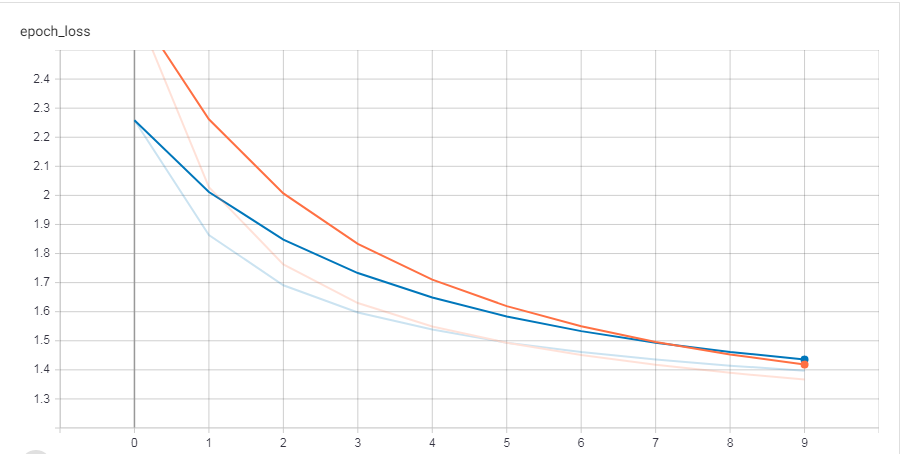

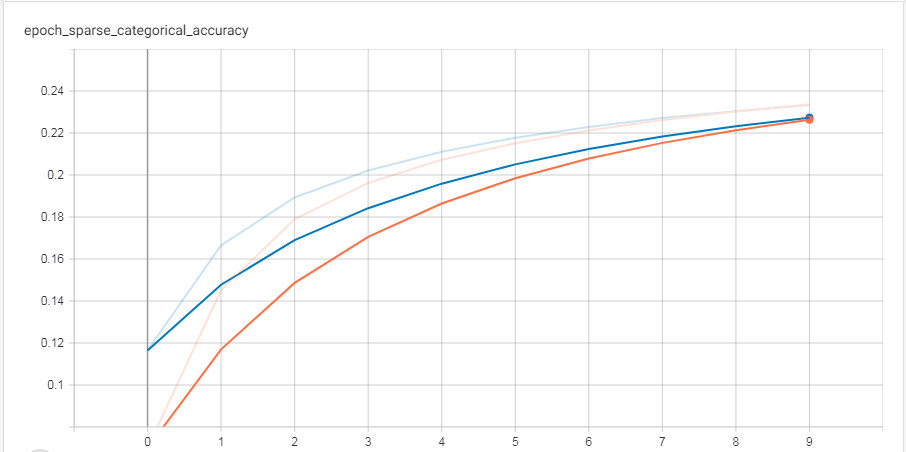

In [ ]:
# Training the model for another 10 epochs

model.fit([train_encoder_inp, train_decoder_inp], train_decoder_out,
          epochs=10, batch_size=BATCH_SIZE, verbose=1,
          validation_data=([val_encoder_inp, val_decoder_inp], val_decoder_out),
          callbacks=[lr_plateau, earlystop_callback, checkpoint_callback, tensorboard_callback])

model.summary()

Epoch 1/10
   1/1112 [..............................] - ETA: 0s - loss: 1.3552 - sparse_categorical_accuracy: 0.2335WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1112/1112 [==============================] - ETA: 0s - loss: 1.3608 - sparse_categorical_accuracy: 0.2349
Epoch 00001: val_loss improved from inf to 1.37840, saving model to ./checkpoint
1112/1112 [==============================] - 1507s 1s/step - loss: 1.3608 - sparse_categorical_accuracy: 0.2349 - val_loss: 1.3784 - val_sparse_categorical_accuracy: 0.2363
Epoch 2/10
1112/1112 [==============================] - ETA: 0s - loss: 1.3222 - sparse_categorical_accuracy: 0.2401
Epoch 00002: val_loss improved from 1.37840 to 1.36293, saving model to ./checkpoint
1112/1112 [==============================] -

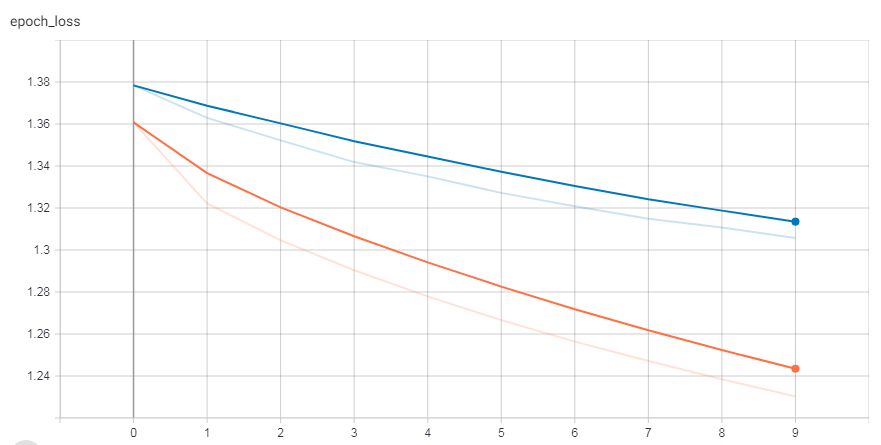

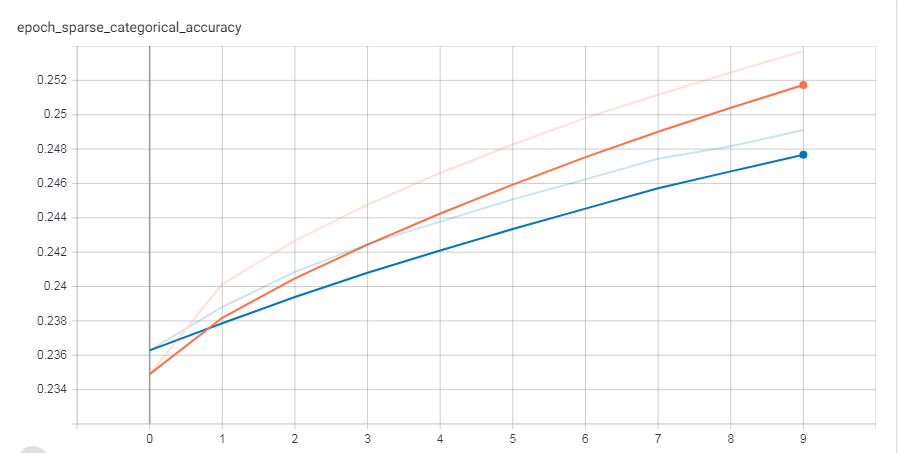

In [ ]:
# After training loading and evaluating trained model

In [ ]:
model.load_weights('./checkpoint')

In [ ]:
model.evaluate([val_encoder_inp, val_decoder_inp], val_decoder_out, batch_size=BATCH_SIZE)

371/371 [==============================] - 232s 625ms/step - loss: 1.3057 - sparse_categorical_accuracy: 0.2491


[1.3057234287261963, 0.24910731613636017]

## Predicting and Testing

### Greedy prediction

In [ ]:
def predict(input_sentence, model):
  '''
  For a given question this function return a answer
  '''
  # To plot attention weights
  attention_plot = np.zeros((MAXLEN, MAXLEN))

  # Preparing input data
  input_tokens = enc_tokenizer.texts_to_sequences([input_sentence])
  input_sequence = pad_sequences(input_tokens, maxlen=MAXLEN, padding='post')

  # Getting encoder output and states
  enc_initial_states = model.encoder.initialize_states(len(input_sequence))
  enc_out, enc_state_h, enc_state_c, enc_mask = model.encoder(input_sequence, enc_initial_states)
  state_h, state_c = enc_state_h, enc_state_c

  # Sending '<start>' as 1st word of decoder
  target_word = np.zeros((1,1))
  target_word[0,0] = dec_tokenizer.word_index['<start>']

  stop_condition = False
  decoded_sent = ''
  pos = 0
  while not stop_condition:
    # decoder layer, intial states are encoder's final states
    output, dec_state_h, dec_state_c, attention_weights, _ = model.decoder.onestepdecoder(target_word, enc_out, state_h, state_c, enc_mask)

    # attention weights
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[pos] = attention_weights.numpy()
         
    out_word_index = np.argmax(output, -1)
    out_word = dec_tokenizer.index_word[out_word_index]
    decoded_sent += " {}".format(out_word)
    
    # Get all the outputs till we don't get '<end>' word or reached maximum output length
    if out_word == '<end>' or len(decoded_sent.split()) >= MAXLEN:
      stop_condition = True

    # current output word is input word for next timestamp
    target_word = np.zeros((1,1))
    target_word[0,0] = out_word_index

    # current out states are input states for next timestamp
    state_h, state_c = dec_state_h, dec_state_c
    pos += 1

  return decoded_sent, input_sentence, attention_plot

In [ ]:
# function for plotting the attention weights
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    """
    Function to plot attention weight.
    It will show output dependecy on inputs
    """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
predict("hi", model)[0]

' inconvenienced mc <end>'

In [ ]:
# Predicting 10 random samples
for i,r in validation.sample(10).iterrows():
    print("Original  :",r['answer_out'])
    print("Predicted :{}".format(predict(r['question'], model)[0]))
    print("-------------------------------------")

Original  : hey there lewis thank you for reaching out to us i want to note that we are aware of this and investigating thanks tv <end>
Predicted : we are aware of this issue and are working on this issue stay tuned for updates to update shortly <end>
-------------------------------------
Original  : hi there sorry about this jack we would definitely expect more from our products can you send me a pic of the barcode please which store did you buy this from robbie <end>
Predicted : hi there i am sorry to see this please dm me your full name address and email so i can log this for you ty chris <end>
-------------------------------------
Original  : i am sorry for the inconvenience have they missed the delivery date given in the order confirmation e mail kb <end>
Predicted : we are sorry to hear this please dm us your email address and we will reach out right away <end>
-------------------------------------
Original  : we hope she came through for you adriana <end>
Predicted : we are glad

Original: i need assistance for amazon cashback
Predicted:  i am sorry for the trouble please connect with our support team here and we will assist you further nk <end>


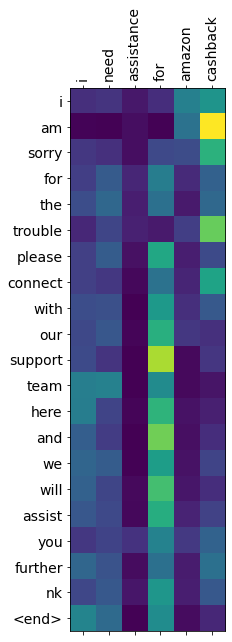

Original: hi i have goflex home hd have green light no white light showing on dock closest it is come to working in months pls help
Predicted:  hi there please check the following link for more information on the tv <end>


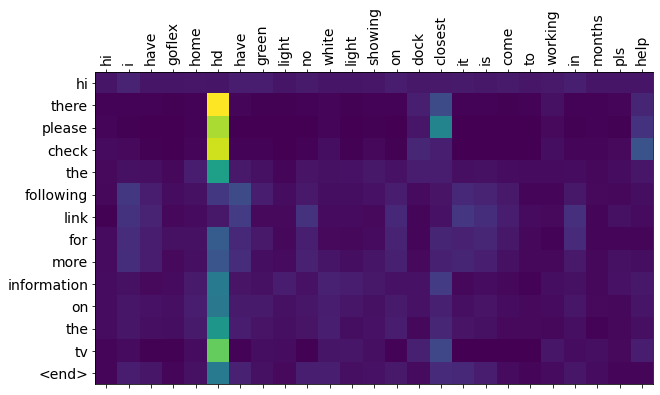

Original: hi trying to find item can you help me please
Predicted:  hi there please reach out to us here so we can look into this for you <end>


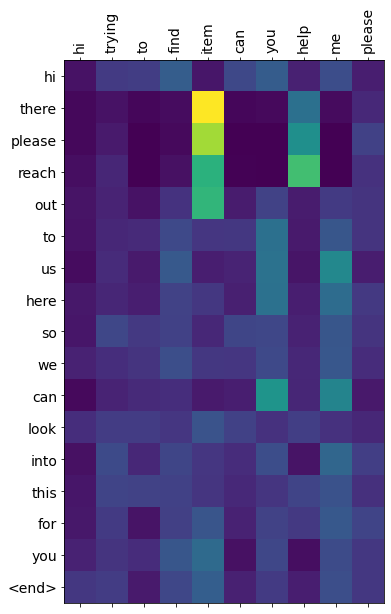

Original: advice from for solving holiday frustration take to social media and be specific with your problem there are people on the other side of the screen that are willing to help just like the social media gurus at
Predicted:  we are sorry to hear this please dm us your email address and we will reach out right away <end>


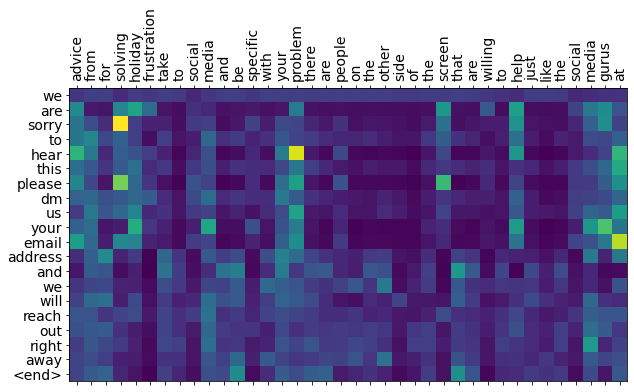

Original: would be nice if when i am told my bill is ready that it meant the pdf version is available i have to remember to check later
Predicted:  hi there i would be happy to look into this for you please dm your full name and address so i can take a look tw <end>


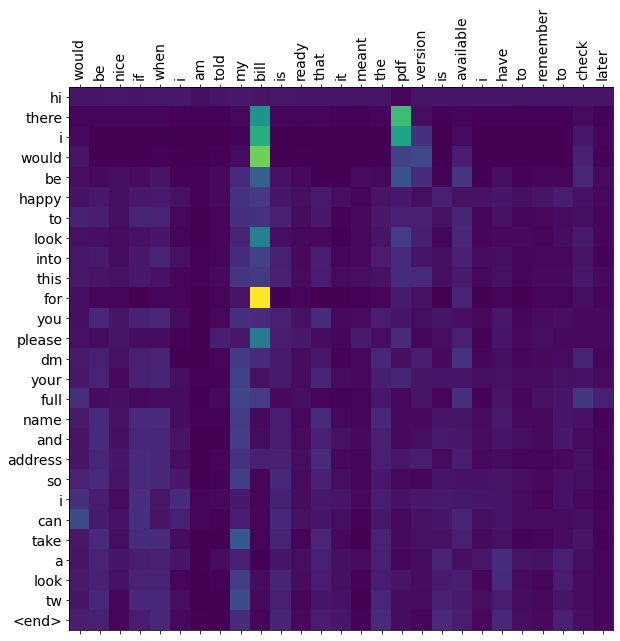

In [ ]:
# Plotting attention weights of 5 random samples
for ind, row in validation.sample(5).iterrows():
    p, s, w = predict(row['question'], model)
    w = w[:len(p.split()), :len(s.split())]
    print("Original:",s)
    print("Predicted:",p)
    plot_attention(w, s.split(),  p.split())

In [ ]:
# Getting BLEU score of 1000 random samples
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
bleu_score_list = []
for ind, row in tqdm(validation.sample(1000).iterrows()):
    original = [row['answer_out'].split(),]
    translated = predict(row['question'], model)[0].split()
    
    bleu_score = bleu.sentence_bleu(original, translated)
    bleu_score_list.append(bleu_score)

avg_blue_score = (sum(bleu_score_list) / len(bleu_score_list))
print("\nAverage BLEU score:", avg_blue_score)

1000it [16:14,  1.03it/s]


Average BLEU score: 0.42301584544167253


### Beam search

In [ ]:
def beam_predict(input_sentence, model, beam_index=3):
    '''
    For a given question this function return a answer
    '''
    # To plot attention weights
    #attention_plot = np.zeros((MAXLEN, MAXLEN))

    # Preparing input data
    input_tokens = enc_tokenizer.texts_to_sequences([input_sentence])
    input_sequence = pad_sequences(input_tokens, maxlen=MAXLEN, padding='post')

    # Getting encoder output and states
    enc_initial_states = model.encoder.initialize_states(len(input_sequence))
    enc_out, enc_state_h, enc_state_c, enc_mask = model.encoder(input_sequence, enc_initial_states)
    state_h, state_c = enc_state_h, enc_state_c

    start_token = dec_tokenizer.word_index['<start>']
    end_token = dec_tokenizer.word_index['<end>']

    # Sending '<start>' as 1st word of decoder
    target_word = np.zeros((1,1))
    target_word[0,0] = start_token

    result = [[[start_token], 0]]

    #pos = 0
    while len(result[0][0]) < MAXLEN:
        temp = []
        for sent_token in result:
            # decoder layer, intial states are encoder's final states
            output, dec_state_h, dec_state_c, attention_weights, _ = model.decoder.onestepdecoder(target_word, enc_out, state_h, state_c, enc_mask)
            # attention weights
            #attention_weights = tf.reshape(attention_weights, (-1, ))
            #attention_plot[pos] = attention_weights.numpy()

            pred_index = np.argsort(output[-1])[-beam_index:]

            for index in pred_index:
                seq, prob = sent_token[0][:], sent_token[1]
                seq.append(index)
                prob += output[-1][index]
                temp.append([seq, prob])
            result = temp

        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]
        #pos += 1

        predicted_list = result[-1][0]
        predicted_index = predicted_list[-1]
        if predicted_index != end_token:
            target_word = np.zeros((1, 1))
            target_word[0,0] = predicted_index
            state_h, state_c = dec_state_h, dec_state_c
        else:
            break

    result = result[-1][0]

    pred_words = [dec_tokenizer.index_word[i] for i in result]    
    pred_sentence = []
    for word in pred_words:
        if word != '<end>':
            pred_sentence.append(word)
        else:
            pred_sentence.append(word)
            break

    return " ".join(pred_sentence[1:])  #, input_sentence, attention_plot

In [ ]:
beam_predict("i need assistance for amazon cashback", model)

'i am sorry for the trouble with the order please contact us here so we can look into this for you cd <end>'

In [ ]:
# Predicting 10 random samples
for i,r in validation.sample(10).iterrows():
    print("Original  :",r['answer_out'])
    print("Predicted :",beam_predict(r['question'], model))
    print("-------------------------------------")

Original  : looking for stranger thing funk pop joyce check in stores online see for more information <end>
Predicted : i there we do not have any info on this right now but we will have it available to you as soon as it is available to us in <end>
-------------------------------------
Original  : please check out to see what steps you can take right away <end>
Predicted : we are here to help send us a do with your email address so we can connect <end>
-------------------------------------
Original  : we have a limited number of gates that we are allowed to use it sounds like the aircraft in the gate your flight was going to use is <end>
Predicted : we are sorry for the delay we will have you wheels up soon <end>
-------------------------------------
Original  : hello dan so sorry to hear that you had problems with our entertainment system can you please do me your confirmation number tom <end>
Predicted : we are sorry to hear this please do your record locator and we will take a look 

Original: extremely lousy service agents lying on phone and no resolution services r terrible dat im forced to dis route
Predicted: we are sorry to hear this please dm us with your email address and we will reach out right away


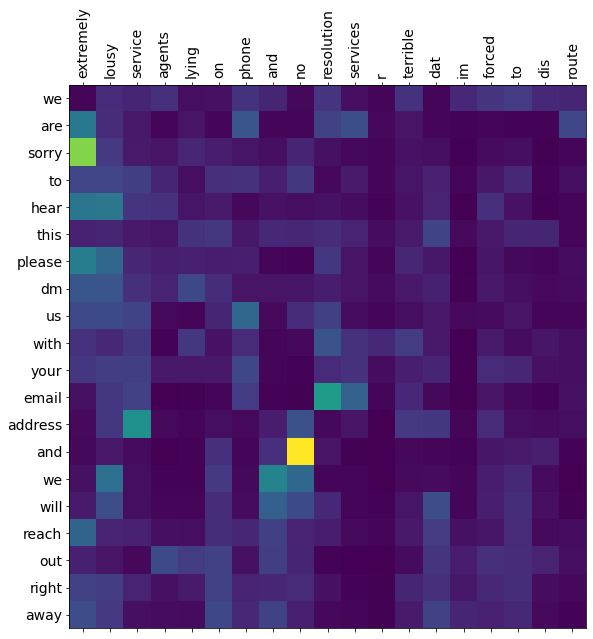

In [ ]:
p, s, w = beam_predict(validation.iloc[0]['question'], model)
w = w[:len(p.split()), :len(s.split())]
print("Original:",s)
print("Predicted:",p)
plot_attention(w, s.split(),  p.split())

Original: i was at this man yells across the aisles as he is coming at me damn you fine can i help you let me help you til he was in my space
Predicted: we are sorry to hear this please dm us with your contact details and store you visited so we can look into this thanks


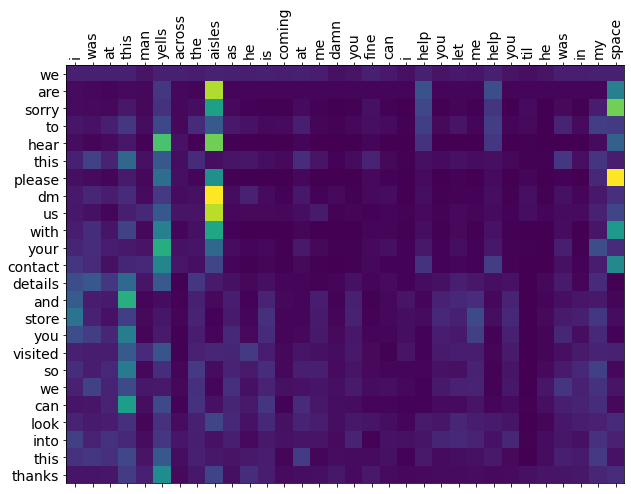

Original: what the heck is there a reason why your customer service blows
Predicted: i am sorry to hear this please dm your tracking number and address so we can look into this for you km


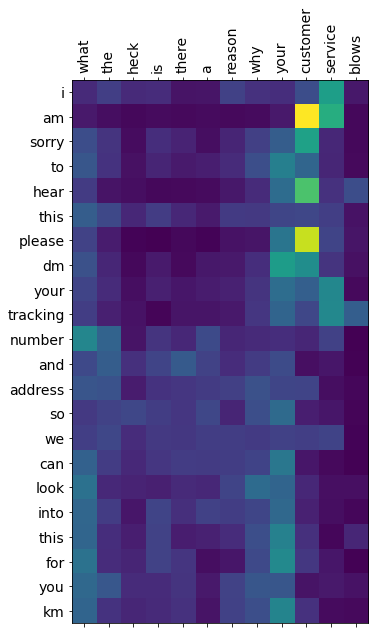

Original: since spotify wants to decline my gift card looks like i am going to have to download apple music again wyd
Predicted: hey there can you dm us your account is email address we will take a look backstage rb


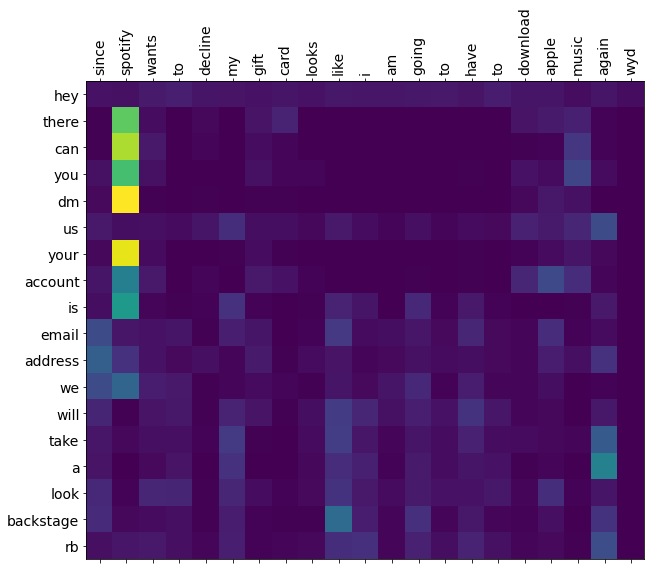

Original: a big thank you to the crew of today for the best hospitality i have ever experienced on a flight
Predicted: we are glad to hear that you enjoyed your flight and we will pass on your kind words to our crew aateam


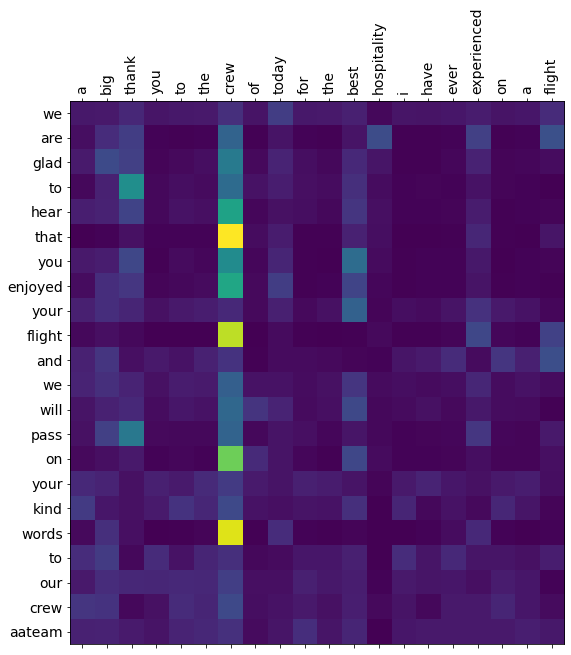

Original: wieso in aller welt kann man in der alexa app nicht mehr mach musik suchen
Predicted: das ist ja nett und versand dich bitte hier meine kollegen im kundenservice diese helfen sk


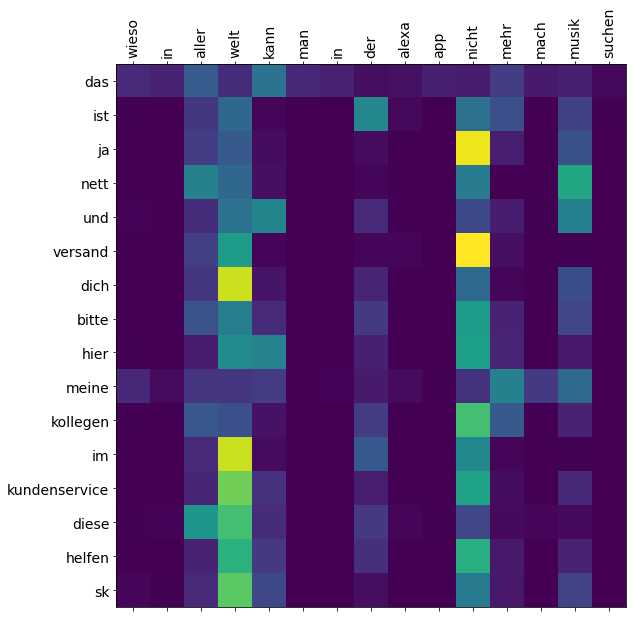

In [ ]:
for _,row in validation.sample(5).iterrows():
    p, s, w = beam_predict(row['question'], model)
    w = w[:len(p.split()), :len(s.split())]
    print("Original:",s)
    print("Predicted:",p)
    plot_attention(w, s.split(),  p.split())

In [ ]:
# Getting BLEU score of 1000 random samples
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
bleu_score_list = []
for ind, row in tqdm(validation.sample(1000).iterrows()):
    original = [row['answer_out'].split(),]
    translated = beam_predict(row['question'], model)[0].split()
    
    bleu_score = bleu.sentence_bleu(original, translated)
    bleu_score_list.append(bleu_score)

avg_blue_score = (sum(bleu_score_list) / len(bleu_score_list))
print("\nAverage BLEU score:", avg_blue_score)

1000it [12:22,  1.35it/s]


Average BLEU score: 0.3802053000190629


In [ ]:
test_sample = validation.sample(10000).copy()

In [ ]:
test_sample.shape

(10000, 3)

In [ ]:
predictions = []
for row in tqdm(test_sample.values):
    predictions.append(beam_predict(row[0], model))

100%|██████████| 10000/10000 [1:47:43<00:00,  1.55it/s]


In [ ]:
test_sample["Predictions"] = predictions

In [ ]:
test_sample.head()

,question,answer_inp,answer_out,Predictions
479742,when y all getting live app for the nvidia shi...,<start> hey jose no news at this time regardin...,hey jose no news at this time regarding live t...,we are always looking to improve our network l...
418576,your internet is so fucking garbage how the fu...,<start> hello i would like to help with the in...,hello i would like to help with the internet i...,hello i apologize for the service issue and i ...
77905,are all your phone lines down i keep getting a...,<start> i am sorry you are having trouble gett...,i am sorry you are having trouble getting thro...,we are here to help please dm us your full add...
247477,perhaps can help with this changed password to...,<start> hey alex we have sent a reply to your ...,hey alex we have sent a reply to your dm let i...,hi there we have just sent a dm your way let i...
50330,i want to get a dell laptop battery,<start> service tag name on the account and em...,service tag name on the account and email addr...,hi we have replied to your dm thank you <end>


In [ ]:
test_sample.shape

(10000, 4)

In [ ]:
pickle.dump(test_sample, open('test_sample.pkl', 'wb'))

In [ ]:
# Getting BLEU score of 1000 random samples
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
bleu_score_list = []
for row in tqdm(test_sample.values):
    original = [row[2].split(),]
    translated = row[3].split()
    
    bleu_score = bleu.sentence_bleu(original, translated)
    bleu_score_list.append(bleu_score)

avg_blue_score = (sum(bleu_score_list) / len(bleu_score_list))
print("\nAverage BLEU score:", avg_blue_score)

100%|██████████| 10000/10000 [00:01<00:00, 5269.97it/s]


Average BLEU score: 0.43263267193201865


### Prediction with batches

In [ ]:
def predict(input_sentence, model):
  '''
  For a given question this function return a answer
  '''
  # Preparing input data
  input_tokens = enc_tokenizer.texts_to_sequences(input_sentence)
  input_sequence = pad_sequences(input_tokens, maxlen=MAXLEN, padding='post')

  batch_size = input_sequence.shape[0]

  # Getting encoder output and states
  enc_initial_states = model.encoder.initialize_states(batch_size)
  enc_out, enc_state_h, enc_state_c, enc_mask = model.encoder(input_sequence, enc_initial_states)
  state_h, state_c = enc_state_h, enc_state_c

  # Sending '<start>' as 1st word of decoder
  target_word = np.zeros((batch_size,1))
  target_word[:,0] = dec_tokenizer.word_index['<start>']

  end_token = dec_tokenizer.word_index["<end>"]

  outwords = []
  while np.array(outwords).shape[0] < MAXLEN:
    # decoder layer, intial states are encoder's final states
    output, dec_state_h, dec_state_c, attention_weights, _ = model.decoder.onestepdecoder(target_word, enc_out, state_h, state_c, enc_mask)
         
    out_word_index = np.argmax(output, -1)
    outwords.append(out_word_index)

    # current output word is input word for next timestamp
    target_word = np.zeros((batch_size,1))
    target_word[:,0] = out_word_index

    # current out states are input states for next timestamp
    state_h, state_c = dec_state_h, dec_state_c
    if (np.array(outwords[-1])==end_token).all():
        break

  sentences = []
  outwords = np.array(outwords)
  for sent_token in outwords.T:
      current_sent = ""
      for ind in sent_token:
          if ind != end_token:
              current_sent += dec_tokenizer.index_word[ind] + " "
          else:
              current_sent += "<end>"
              break
      sentences.append(current_sent.strip())

  return sentences

In [ ]:
predict(['need help from you'], model)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



['i there we are here to help please send us a message and we will get started helping you out <end>']

In [ ]:
validation.shape[0]

177849

In [ ]:
start=0
batch = 128
count = 1
result = []

start_time = time.time()
while start < validation.shape[0]:
    batch_result = predict(validation['question'].iloc[start:start+batch], model)
    result.extend(batch_result)
    
    if (start // (count*10000))==1:
        end_time = time.time()
        print(f"Done : {count*10000} and time taken: {np.round(end_time-start_time, 2)} seconds")
        count += 1
    
    start = start+batch

Done : 10000 and time taken: 55.78 seconds
Done : 20000 and time taken: 110.54 seconds
Done : 30000 and time taken: 165.3 seconds
Done : 40000 and time taken: 219.95 seconds
Done : 50000 and time taken: 275.13 seconds
Done : 60000 and time taken: 330.59 seconds
Done : 70000 and time taken: 385.52 seconds
Done : 80000 and time taken: 440.47 seconds
Done : 90000 and time taken: 496.27 seconds
Done : 100000 and time taken: 551.86 seconds
Done : 110000 and time taken: 608.03 seconds
Done : 120000 and time taken: 663.89 seconds
Done : 130000 and time taken: 719.33 seconds
Done : 140000 and time taken: 774.15 seconds
Done : 150000 and time taken: 829.15 seconds
Done : 160000 and time taken: 884.9 seconds
Done : 170000 and time taken: 941.6 seconds


In [ ]:
validation['Predictions'] = result

In [ ]:
# Getting BLEU score of 1000 random samples
# After 20 epoch spell corrected
import nltk.translate.bleu_score as bleu
from tqdm import tqdm

bleu_score_list = []
for row in tqdm(validation.values):
    original = [row[2].split(),]
    translated = row[3].split()
    
    bleu_score = bleu.sentence_bleu(original, translated)
    bleu_score_list.append(bleu_score)

avg_blue_score = (sum(bleu_score_list) / len(bleu_score_list))
print("\nAverage BLEU score:", avg_blue_score)

100%|██████████| 177849/177849 [00:35<00:00, 4969.03it/s]


Average BLEU score: 0.4310485454195498


In [ ]:
validation['bleu_score'] = bleu_score_list

In [ ]:
validation.shape

(177849, 5)

In [ ]:
validation.head()

,question,answer_inp,answer_out,Predictions,bleu_score
360043,wow worst experience ever from orange county s...,<start> we are very sorry to hear that we coun...,we are very sorry to hear that we count on our...,we are sorry to hear this please do us your em...,0.199264
730552,overall had a good time last night but our dri...,<start> i there can you please do us some deta...,i there can you please do us some detail about...,we are sorry to hear this was your experience ...,0.644672
196978,can i get a capable person to deal with your i...,<start> apologies for this sharon we are urgen...,apologies for this sharon we are urgently foll...,i would be happy to look into this for you ple...,0.652994
102306,main delay equip change chs gate agents did a ...,<start> that is fantastic to hear our agents a...,that is fantastic to hear our agents are the b...,we are so glad you enjoyed your flight we will...,0.335254
828940,shout out to for ruining my experience watchin...,<start> i would be happy to help you with any ...,i would be happy to help you with any speed is...,i am sorry for the poor experience can you ple...,0.707107


In [ ]:
pickle.dump(validation, open("spellval_predicted.pkl", "wb"))